In [29]:
#!pip install tensorflow
#!pip install keras
#!pip install torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from torch.utils.data import DataLoader, TensorDataset
from vae import VAE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from keras.models import Model
from keras.layers import Input, Dense

In [3]:
# Проверка версии TensorFlow
print(tf.__version__)


2.16.1


ML Case HW

# Задание 1. 
Сделать сравнение табличных unsupervised детекторов аномалий (не менее 5) по метрики gini на одном из датасетов на выбор: синтетический и реальный.

1. Загрузка и анализ датасета. Содержится минимум 3 ячейки с разведочным анализом данных (например, кол-во наблюдений в каждой группе таргета)

In [13]:
# Загрузка данных
data = pd.read_csv('C:/Users/pavle/OneDrive/Desktop/ml_case/creditcard.csv')


In [14]:
# Основная информация о датасете
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [15]:
# Количество наблюдений в каждой группе таргета
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [16]:
# Распределение признаков
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


2. Инициализация всех алгоритмов.

Для сравнения мы будем использовать следующие модели:

- Isolation Forest
- Local Outlier Factor (LOF)
- One-Class SVM
- Elliptic Envelope
- AutoEncoder (используем Keras для создания модели)

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# Инициализация моделей
iso_forest = IsolationForest(contamination=0.01)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
one_class_svm = OneClassSVM(nu=0.01)
elliptic_envelope = EllipticEnvelope(contamination=0.01)

# Создание модели AutoEncoder
input_dim = data.shape[1] - 1  # исключаем целевую переменную 'Class'
input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation="tanh")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(14, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Вывод структуры AutoEncoder
autoencoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           434 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,101 (4.30 KB)

 Trainable params: 1,101 (4.30 KB)

 Non-trainable params: 0 (0.00 B)

3. Обучение всех алгоритмов. В ячейке с обучением модели сохранен лог(вывод) процесса обучения.

In [6]:
# Разделение данных на тренировочную и тестовую выборки
X = data.drop(columns=['Class'])
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучение моделей и сохранение лога процесса обучения

In [7]:
# Isolation Forest
iso_forest.fit(X_train)
iso_forest_preds = iso_forest.predict(X_test)


In [8]:
# Local Outlier Factor (LOF)
lof_preds = lof.fit_predict(X_test)

In [9]:
# One-Class SVM
one_class_svm.fit(X_train)
one_class_svm_preds = one_class_svm.predict(X_test)

In [10]:
# Elliptic Envelope
elliptic_envelope.fit(X_train)
elliptic_envelope_preds = elliptic_envelope.predict(X_test)

c:\Users\pavle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-84.634261877272507 > -84.761857203559572). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\pavle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-60.957729972955988 > -61.894054710326280). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\Users\pavle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\covariance\_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-144.919832474569802 > -312.810320548962181). You may want to 

In [11]:
# Обучение AutoEncoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, validation_split=0.2, verbose=1)
autoencoder_preds = autoencoder.predict(X_test)

Epoch 1/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step - loss: 375021824.0000 - val_loss: 373544544.0000
Epoch 2/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 374257632.0000 - val_loss: 373475488.0000
Epoch 3/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 374761568.0000 - val_loss: 373407488.0000
Epoch 4/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 374064736.0000 - val_loss: 373339776.0000
Epoch 5/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 373539872.0000 - val_loss: 373272288.0000
Epoch 6/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 374715808.0000 - val_loss: 373204928.0000
Epoch 7/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 374171584.0000 - val_loss: 373137376.0000
Epoch 8/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 373615712.0000 - val_loss: 373069984.0000
Epoch 9/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 373498368.0000 - val_loss: 373002784.0000
Epoch 10/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - loss: 3

4. Вывод метрики для всех алгоритмов на тестовой выборке в единую табличку. Размер тестовой выборки должен составлять не менее 20% от исходной выборки

In [12]:
# Функция для вычисления Gini
def gini(y_true, y_prob):
    return 2 * roc_auc_score(y_true, y_prob) - 1

# Преобразование предсказаний для всех моделей
iso_forest_scores = -iso_forest.decision_function(X_test)
lof_scores = -lof.negative_outlier_factor_
one_class_svm_scores = -one_class_svm.decision_function(X_test)
elliptic_envelope_scores = -elliptic_envelope.decision_function(X_test)
autoencoder_scores = np.mean(np.power(X_test - autoencoder_preds, 2), axis=1)

# Вычисление метрики Gini для всех моделей
iso_forest_gini = gini(y_test, iso_forest_scores)
lof_gini = gini(y_test, lof_scores)
one_class_svm_gini = gini(y_test, one_class_svm_scores)
elliptic_envelope_gini = gini(y_test, elliptic_envelope_scores)
autoencoder_gini = gini(y_test, autoencoder_scores)

# Создание таблицы с результатами
results = pd.DataFrame({
    'Model': ['Isolation Forest', 'Local Outlier Factor', 'One-Class SVM', 'Elliptic Envelope', 'AutoEncoder'],
    'Gini': [iso_forest_gini, lof_gini, one_class_svm_gini, elliptic_envelope_gini, autoencoder_gini]
})

print(results)


                  Model      Gini
0      Isolation Forest  0.910465
1  Local Outlier Factor  0.199898
2         One-Class SVM  0.056804
3     Elliptic Envelope  0.867955
4           AutoEncoder -0.100779


Результаты показывают эффективность различных моделей обнаружения аномалий по метрике Gini. 

Isolation Forest (Gini = 0.910465): показывает самый высокий результат по метрике Gini. Модель эффективно различает нормальные и аномальные транзакции.

Elliptic Envelope (Gini = 0.867955): также показала высокий результат, что указывает на ее способность хорошо справляться с задачей обнаружения аномалий на данном датасете. Этот алгоритм предполагает, что данные имеют гауссово распределение, что, возможно, близко к истине для этого набора данных.

Local Outlier Factor (LOF) (Gini = 0.199898): показал значительно более низкий результат по сравнению с Isolation Forest и Elliptic Envelope. Это может свидетельствовать о том, что LOF менее эффективен для этого конкретного набора данных или требует дополнительной настройки параметров. Может требоваться больше соседей для более точной оценки плотности. Данные могут не соответствовать предположениям модели.

One-Class SVM (Gini = 0.056804): показывает почти нулевой результат, что означает, что модель почти не различает нормальные и аномальные транзакции. Это может быть связано с недостаточной настройкой гиперпараметров или неадекватной моделью для данного типа данных. Модель может не подходить для высокоразмерных данных. Необходима настройка параметров, таких как ядро (kernel) и параметр ν (nu).

AutoEncoder (Gini = -0.100779): показал отрицательный результат, что является очень плохим показателем. Это может говорить о том, что модель AutoEncoder не смогла обучиться эффективно из-за недостаточного количества данных, неправильной архитектуры или гиперпараметров, либо из-за необходимости более тщательной настройки. Неправильная архитектура нейронной сети (например, недостаточная глубина или количество нейронов). Плохое качество данных для обучения (например, несбалансированные данные).

Вывод: Isolation Forest и Elliptic Envelope показали хорошие результаты и могут быть использованы в дальнейшем для этого набора данных.
Local Outlier Factor, One-Class SVM, и AutoEncoder требуют дополнительной настройки и анализа. Возможно, стоит рассмотреть альтернативные архитектуры для AutoEncoder или изменить гиперпараметры для SVM и LOF.

# Задание 2. 
В библиотеке PYOD VAE написан с использованием keras. Реализуйте VAE на torch.

Реализация VAE: https://github.com/yzhao062/pyod/blob/master/pyod/models/vae.py

1. Загрузка и анализ датасета

In [18]:
# Загрузка данных
data = pd.read_csv('C:/Users/pavle/OneDrive/Desktop/ml_case/creditcard.csv')


In [19]:
# Разведочный анализ данных
print(data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [20]:
print(data.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [21]:
print(data['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


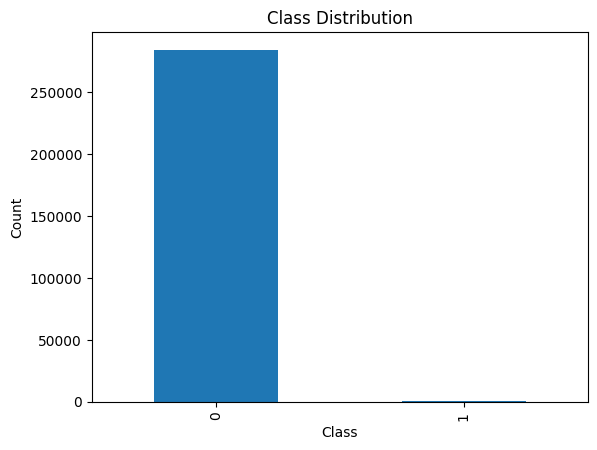

In [22]:
# Визуализация количества наблюдений в каждой группе таргета
data['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [23]:
# Разделение данных на тренировочную и тестовую выборки
X = data.drop(columns=['Class'])
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

2. Реализовать VAE на torch

In [27]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(VAE, self).__init__()
        self.encoder = self.build_network(input_dim, hidden_dims, latent_dim * 2)
        self.decoder = self.build_network(latent_dim, hidden_dims[::-1], input_dim)
        
    def build_network(self, input_dim, hidden_dims, output_dim):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, output_dim))
        return nn.Sequential(*layers)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        
        # Reparameterization
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    def loss_function(self, x, x_reconstructed, mu, log_var):
        recon_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kl_loss

# Сохранение в файл vae.py
with open('vae.py', 'w') as f:
    f.write("""
import torch
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(VAE, self).__init__()
        self.encoder = self.build_network(input_dim, hidden_dims, latent_dim * 2)
        self.decoder = self.build_network(latent_dim, hidden_dims[::-1], input_dim)
        
    def build_network(self, input_dim, hidden_dims, output_dim):
        layers = []
        for h_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, h_dim))
            layers.append(nn.ReLU())
            input_dim = h_dim
        layers.append(nn.Linear(input_dim, output_dim))
        return nn.Sequential(*layers)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        
        # Reparameterization
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var

    def loss_function(self, x, x_reconstructed, mu, log_var):
        recon_loss = nn.functional.mse_loss(x_reconstructed, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kl_loss
""")

print("VAE implementation saved to vae.py")


  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/159.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/159.8 MB 1.6 MB/s eta 0:01:40
   ---------------------------------------- 0.2/159.8 MB 2.5 MB/s eta 0:01:05
   ---------------------------------------- 0.5/159.8 MB 3.9 MB/s eta 0:00:41
   ---------------------------------------- 1.0/159.8 MB 5.9 MB/s eta 0:00:27
   ---------------------------------------- 1.6/159.8 MB 7.4 MB/s eta 0:00:22
    --------------------------------------- 2.4/159.8 MB 8.9 MB/s eta 0:00:18
    --------------------------------------- 3.5/159.8 MB 11.2 MB/s eta 0:00:14
   - -------------------------------------- 4.7/159.8 MB 13.0 MB/s eta 0:00:12
   - -------------------------------------- 6.1/159.8 MB 14.9 MB/s eta 0:00:11
   - -------------------------------------- 7.3/159.8 MB 16.0 MB/s eta 0:00:10
   -- ------------------------------------- 8.7/159.8 MB 17.4 MB/s eta 0:00:09
   

3. Сохранить рабочую реализацию в файле с расширением .py

Сохранено в ячейке выше.

4. Обучение модели и вывод результатов 

In [28]:
# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Создание DataLoader для тренировочной и тестовой выборок
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Инициализация модели, оптимизатора и функции потерь
input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]
latent_dim = 2
vae = VAE(input_dim, hidden_dims, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Обучение модели
num_epochs = 100
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for x_batch in train_loader:
        x_batch = x_batch[0]
        optimizer.zero_grad()
        x_reconstructed, mu, log_var = vae(x_batch)
        loss = vae.loss_function(x_batch, x_reconstructed, mu, log_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

# Вывод результатов
vae.eval()
with torch.no_grad():
    test_loss = 0
    for x_batch in test_loader:
        x_batch = x_batch[0]
        x_reconstructed, mu, log_var = vae(x_batch)
        loss = vae.loss_function(x_batch, x_reconstructed, mu, log_var)
        test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')


Epoch 1, Loss: 26.5758
Epoch 2, Loss: 23.9425
Epoch 3, Loss: 23.0145
Epoch 4, Loss: 22.4149
Epoch 5, Loss: 21.7334
Epoch 6, Loss: 21.2266
Epoch 7, Loss: 21.1968
Epoch 8, Loss: 20.8079
Epoch 9, Loss: 20.7365
Epoch 10, Loss: 20.6105
Epoch 11, Loss: 20.6760
Epoch 12, Loss: 20.5671
Epoch 13, Loss: 20.5819
Epoch 14, Loss: 20.6173
Epoch 15, Loss: 20.3113
Epoch 16, Loss: 20.2944
Epoch 17, Loss: 20.0063
Epoch 18, Loss: 19.8835
Epoch 19, Loss: 19.5635
Epoch 20, Loss: 19.3621
Epoch 21, Loss: 19.2727
Epoch 22, Loss: 19.2164
Epoch 23, Loss: 19.2883
Epoch 24, Loss: 19.0760
Epoch 25, Loss: 18.9045
Epoch 26, Loss: 18.9492
Epoch 27, Loss: 18.9664
Epoch 28, Loss: 27.4430
Epoch 29, Loss: 19.0233
Epoch 30, Loss: 18.9498
Epoch 31, Loss: 19.0433
Epoch 32, Loss: 19.0543
Epoch 33, Loss: 18.9208
Epoch 34, Loss: 18.7433
Epoch 35, Loss: 18.8706
Epoch 36, Loss: 18.8364
Epoch 37, Loss: 18.7114
Epoch 38, Loss: 18.7671
Epoch 39, Loss: 18.5604
Epoch 40, Loss: 18.7263
Epoch 41, Loss: 18.8229
Epoch 42, Loss: 18.5512
E

Loss уменьшался с каждой эпохой, что говорит о том, что модель научилась реконструировать данные и регуляризовать латентное пространство, близкое к априорному распределению. Однако более глубокие выводы нужно будет сделать, если бы в задании требовалось сравнить с другими алгоритмами.